# Extra Baseline to Compare LightSB Method

This notebook encompasses an extra baseline before applying more rigorous and computationally expensive transforms to the images. It explores more classical techniques, such as histogram equalization and gamma correction.

In [42]:
# Appends the YOLOPX directory to the path, so we can import the BDD100K dataloader
import os, sys

path = os.getcwd()
BASE_DIR = os.path.dirname(os.path.dirname(path))
print(BASE_DIR)
assert(os.path.basename(BASE_DIR) == "LightSB_YOLO")
YOLOPX_DIR = os.path.join(BASE_DIR, "", "models\YOLOPX")

sys.path.append(YOLOPX_DIR)
print(YOLOPX_DIR)

c:\Users\joche\Development\Github\LightSB_YOLO
c:\Users\joche\Development\Github\LightSB_YOLO\models\YOLOPX


# Setup Config

In [43]:
from argparse import Namespace
from lib.config import cfg, update_config

args = Namespace()
args.iou_thres = 0.6
args.conf_thres = 0.001
args.weights = "../../weights/epoch-195.pth"
args.modelDir = ''
args.logDir = 'runs/'

# annotations directory setup
args.da_seg_annotations = os.path.join(BASE_DIR, '', 'data/da_seg_annotations')
args.det_annotations = os.path.join(BASE_DIR, '', 'data/det_annotations')
args.images = os.path.join(BASE_DIR, '', 'data/images')
args.ll_seg_annotations = os.path.join(BASE_DIR, '', 'data/ll_seg_annotations')
update_config(cfg, args)

In [44]:
# Get device
from lib.utils.utils import select_device

# No logger, otherwise switch out none for logger
device = select_device(None, batch_size=cfg.TEST.BATCH_SIZE_PER_GPU* len(cfg.GPUS)) if not cfg.DEBUG \
            else select_device(None, 'cpu')

# Model

In [58]:
import torch
from lib.models import get_net
from lib.core.loss import get_loss

model = get_net(cfg)
criterion = get_loss(cfg, device, model)

model_dict = model.state_dict()
checkpoint = torch.load(args.weights, map_location=device)
checkpoint_dict = checkpoint['state_dict']

model_dict.update(checkpoint_dict)
model.load_state_dict(model_dict)
model = model.to(device)
model.gr = 1.0
model.nc = 1
print('bulid model finished')

bulid model finished


# Histogram Equalization

In [59]:
# Data
# Get the full validation dataset

import lib.dataset as dataset
import torchvision.transforms as transforms
import pickle as pkl
import copy

pkl_dir = os.path.join(os.getcwd(), 'pkl_files', 'full_validation_dataset.pkl')

# Check if we can skip building the db
skippable = os.path.exists(pkl_dir)
print(pkl_dir)
print("Skippable:", skippable)

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

full_validation_dataset = dataset.BddDataset(
    cfg=cfg,
    is_train=False, # validation set
    inputsize=cfg.MODEL.IMAGE_SIZE,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]), 
    skip=skippable # skip = true will not build the db
)

# if this is the first run, save the db to a pkl file
if not skippable:
    with open(pkl_dir, 'wb') as f:
        pkl.dump(full_validation_dataset.db, f)

else:
    with open(pkl_dir, 'rb') as f:
        full_validation_dataset.db = pkl.load(f)


print('Full validation set samples:', len(full_validation_dataset.db))

val_day_and_night = copy.copy(full_validation_dataset)
val_day_and_night.db = val_day_and_night.select_data(timeofday='all')
print('Day and night samples:', len(val_day_and_night.db))

val_day = copy.copy(full_validation_dataset)
val_day.db = val_day.select_data(timeofday='daytime')
print('Daytime samples:', len(val_day.db))

val_night = copy.copy(full_validation_dataset)
val_night.db = val_night.select_data(timeofday='night')
print('Night samples:', len(val_night.db))
print('Not included samples:', len(full_validation_dataset.db) - len(val_day.db) - len(val_night.db))

c:\Users\joche\Development\Github\LightSB_YOLO\notebooks\baseline\pkl_files\full_validation_dataset.pkl
Skippable: True
Full validation set samples: 10000
Day and night samples: 9222
Daytime samples: 5258
Night samples: 3929
Not included samples: 813


c:\Users\joche\anaconda3\envs\yolopx_lightsb\lib\site-packages\albumentations\core\composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

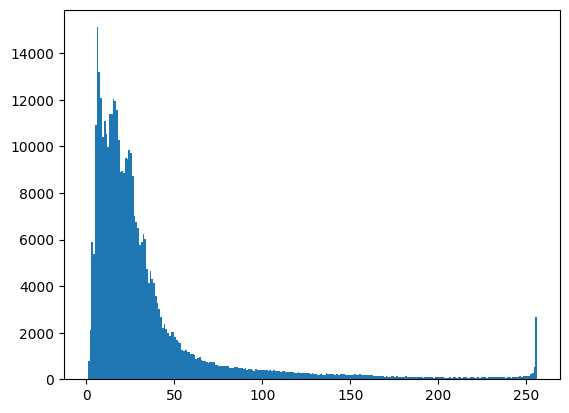

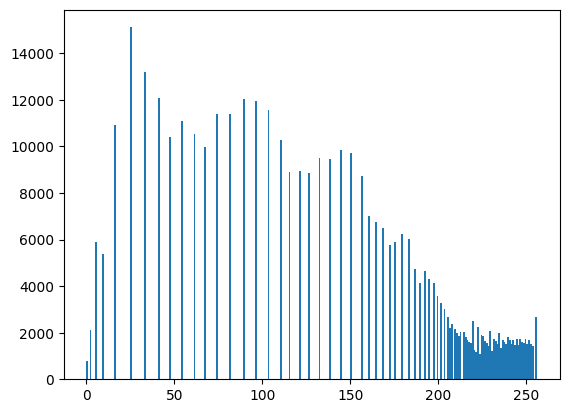

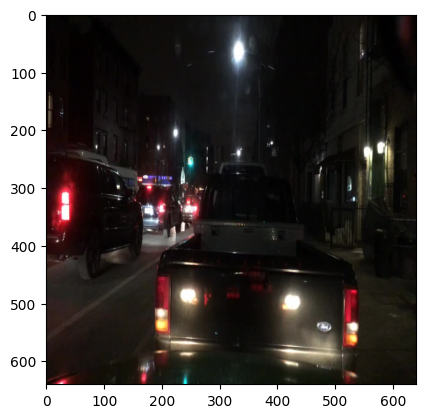

<function matplotlib.pyplot.show(close=None, block=None)>

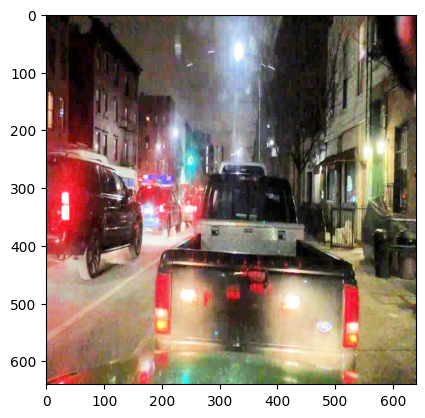

In [63]:
# https://www.geeksforgeeks.org/python/histograms-equalization-opencv/

img = cv2.imread(val_night.db[100]['image'])
img = cv2.resize(img, (640, 640))

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.hist(hsv[:,:,2].ravel(),256,[0,256])
plt.show()

equal_hist_luminance = cv2.equalizeHist(hsv[:,:,2])
hsv[:,:,2] = equal_hist_luminance
plt.hist(hsv[:,:,2].ravel(),256,[0,256])
plt.show()

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

img2 = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
plt.imshow(img2)
plt.show


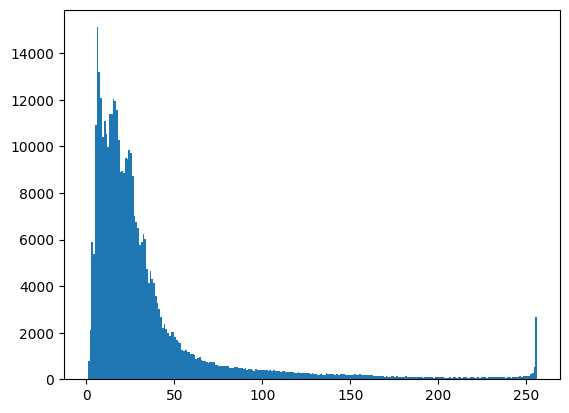

(640, 640, 3)


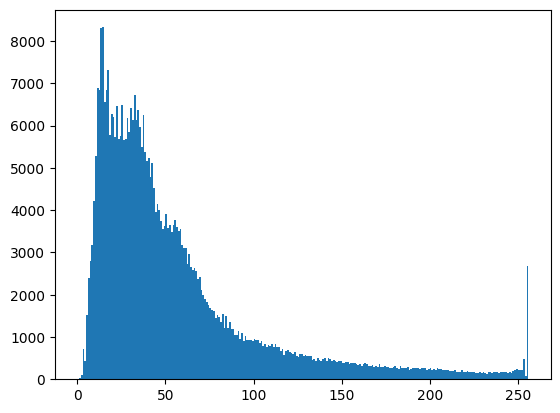

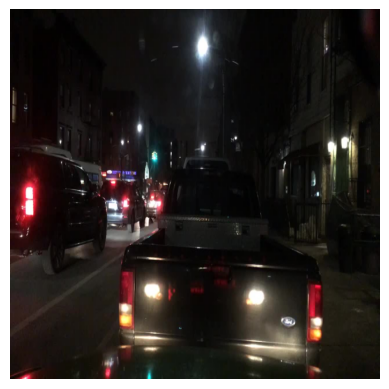

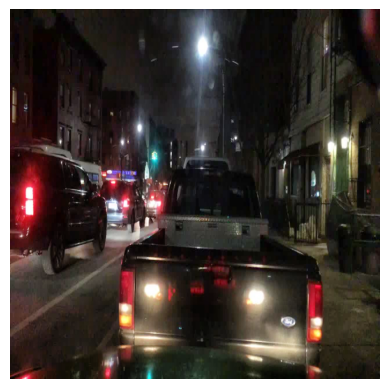

In [65]:
# https://www.geeksforgeeks.org/python/clahe-histogram-eqalization-opencv/
img = cv2.imread(val_night.db[100]['image'])
img = cv2.resize(img, (640, 640))

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.hist(hsv[:,:,2].ravel(),256,[0,256])
plt.show()

clahe = cv2.createCLAHE(clipLimit=2) 
hsv[:,:,2] = np.clip(clahe.apply(hsv[:,:,2]), 0, 255).astype(np.uint8)
print(hsv.shape)

plt.hist(hsv[:,:,2].ravel(),256,[0,256]) 
plt.show()


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

img2 = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
plt.imshow(img2)
plt.axis('off')
plt.show()


# CLAHE YOLOPX RUN

### Config

In [49]:
# Activate CLAHE in config
cfg.defrost()
cfg.DATASET.CLAHE_VAL = True
cfg.DATASET.CLAHE_CLIPLIMIT = 2.0
cfg.freeze()

### CLAHE Dataset

c:\Users\joche\Development\Github\LightSB_YOLO\notebooks\baseline\pkl_files\full_validation_dataset.pkl
Skippable: True
Full validation set samples: 10000
Day and night samples: 9222
Daytime samples: 5258
Night samples: 3929
Not included samples: 813


c:\Users\joche\anaconda3\envs\yolopx_lightsb\lib\site-packages\albumentations\core\composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


### CLAHE Day-And-Night

In [51]:
from lib.utils import DataLoaderX
 
valid_loader = DataLoaderX(
    val_day_and_night,
    batch_size=cfg.TEST.BATCH_SIZE_PER_GPU * len(cfg.GPUS),
    shuffle=False,
    num_workers=cfg.WORKERS,
    pin_memory=False,
    collate_fn=dataset.AutoDriveDataset.collate_fn
)

print('load data finished')

load data finished


100%|██████████| 1153/1153 [13:43<00:00,  1.40it/s]


                 all    9.22e+03    9.93e+04      0.0335       0.934       0.823       0.478
Speed: 0.0/0.0/0.0 ms inference/NMS/total per 640x640 image at batch-size 8
Results saved to \visualization
Test:    Loss(0.473)
Driving area Segment: Acc(0.979)    IOU (0.886)    mIOU(0.930)
Lane line Segment: Acc(0.874)    IOU (0.267)  mIOU(0.623)
Detect: P(0.034)  R(0.934)  mAP@0.5(0.823)  mAP@0.5:0.95(0.478)
Time: inference(0.0395s/frame)  nms(0.0046s/frame)


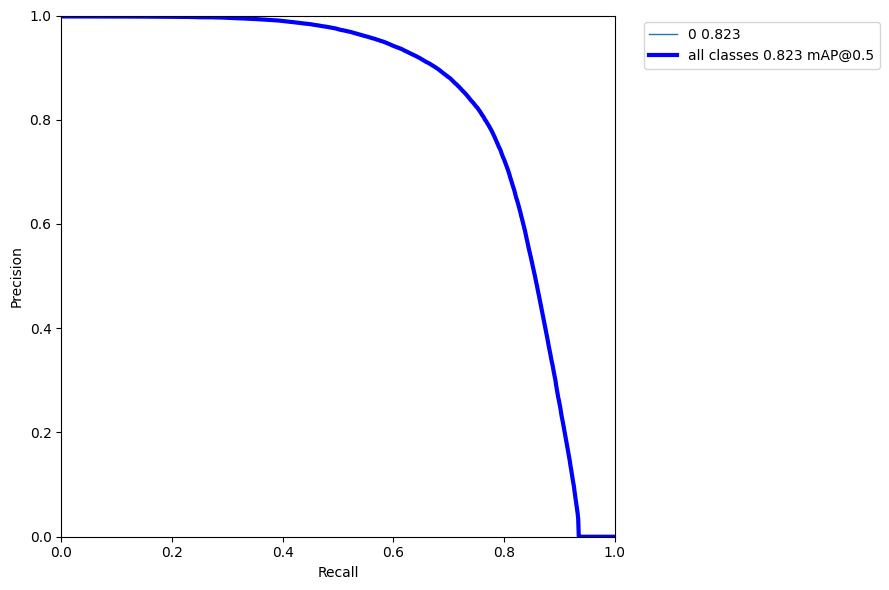

In [52]:
from lib.core.function import validate
from lib.core.general import fitness

epoch = 0
da_segment_results,ll_segment_results,detect_results, total_loss,maps, times = validate(
    epoch,cfg, valid_loader, val_day_and_night, model, criterion,
    "", "", "",
    "", device
)

fi = fitness(np.array(detect_results).reshape(1, -1))
msg =   'Test:    Loss({loss:.3f})\n' \
        'Driving area Segment: Acc({da_seg_acc:.3f})    IOU ({da_seg_iou:.3f})    mIOU({da_seg_miou:.3f})\n' \
                  'Lane line Segment: Acc({ll_seg_acc:.3f})    IOU ({ll_seg_iou:.3f})  mIOU({ll_seg_miou:.3f})\n' \
                  'Detect: P({p:.3f})  R({r:.3f})  mAP@0.5({map50:.3f})  mAP@0.5:0.95({map:.3f})\n'\
                  'Time: inference({t_inf:.4f}s/frame)  nms({t_nms:.4f}s/frame)'.format(
                      loss=total_loss, da_seg_acc=da_segment_results[0],da_seg_iou=da_segment_results[1],da_seg_miou=da_segment_results[2],
                      ll_seg_acc=ll_segment_results[0],ll_seg_iou=ll_segment_results[1],ll_seg_miou=ll_segment_results[2],
                      p=detect_results[0],r=detect_results[1],map50=detect_results[2],map=detect_results[3],
                      t_inf=times[0], t_nms=times[1])

print(msg)

### CLAHE Night-Only

load data finished


100%|██████████| 492/492 [04:58<00:00,  1.65it/s]


                 all    3.93e+03     3.7e+04      0.0292       0.932       0.785       0.421
Speed: 0.0/0.0/0.0 ms inference/NMS/total per 640x640 image at batch-size 8
Results saved to \visualization
Test:    Loss(0.508)
Driving area Segment: Acc(0.977)    IOU (0.879)    mIOU(0.926)
Lane line Segment: Acc(0.861)    IOU (0.261)  mIOU(0.621)
Detect: P(0.029)  R(0.932)  mAP@0.5(0.785)  mAP@0.5:0.95(0.421)
Time: inference(0.0379s/frame)  nms(0.0041s/frame)


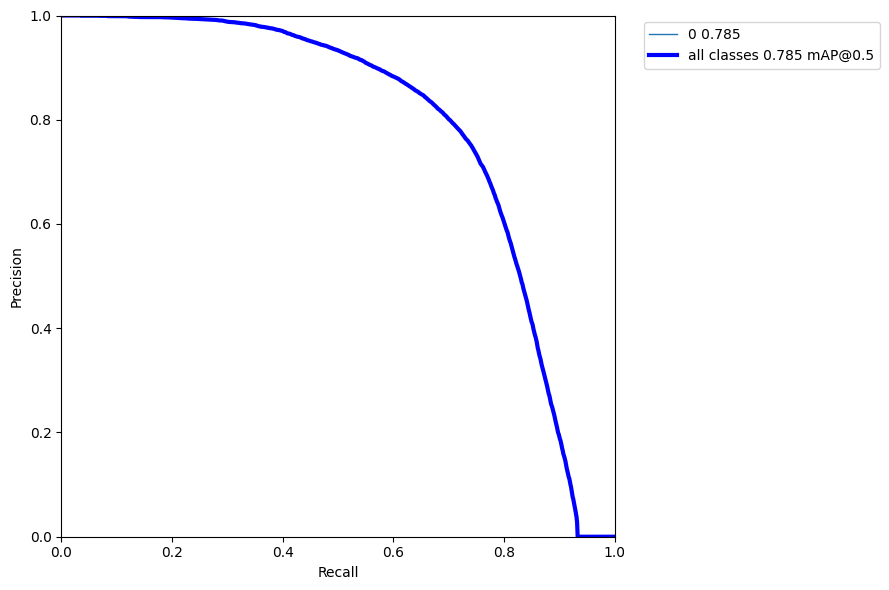

In [53]:
from lib.utils import DataLoaderX
 
valid_loader = DataLoaderX(
    val_night,
    batch_size=cfg.TEST.BATCH_SIZE_PER_GPU * len(cfg.GPUS),
    shuffle=False,
    num_workers=cfg.WORKERS,
    pin_memory=False,
    collate_fn=dataset.AutoDriveDataset.collate_fn
)

print('load data finished')

epoch = 0
da_segment_results,ll_segment_results,detect_results, total_loss,maps, times = validate(
    epoch,cfg, valid_loader, val_night, model, criterion,
    "", "", "",
    "", device
)

fi = fitness(np.array(detect_results).reshape(1, -1))
msg =   'Test:    Loss({loss:.3f})\n' \
        'Driving area Segment: Acc({da_seg_acc:.3f})    IOU ({da_seg_iou:.3f})    mIOU({da_seg_miou:.3f})\n' \
                  'Lane line Segment: Acc({ll_seg_acc:.3f})    IOU ({ll_seg_iou:.3f})  mIOU({ll_seg_miou:.3f})\n' \
                  'Detect: P({p:.3f})  R({r:.3f})  mAP@0.5({map50:.3f})  mAP@0.5:0.95({map:.3f})\n'\
                  'Time: inference({t_inf:.4f}s/frame)  nms({t_nms:.4f}s/frame)'.format(
                      loss=total_loss, da_seg_acc=da_segment_results[0],da_seg_iou=da_segment_results[1],da_seg_miou=da_segment_results[2],
                      ll_seg_acc=ll_segment_results[0],ll_seg_iou=ll_segment_results[1],ll_seg_miou=ll_segment_results[2],
                      p=detect_results[0],r=detect_results[1],map50=detect_results[2],map=detect_results[3],
                      t_inf=times[0], t_nms=times[1])

print(msg)

### CLAHE Day-Only

load data finished


100%|██████████| 658/658 [06:08<00:00,  1.78it/s]


                 all    5.26e+03    6.21e+04      0.0368       0.935       0.843        0.51
Speed: 0.0/0.0/0.0 ms inference/NMS/total per 640x640 image at batch-size 8
Results saved to \visualization
Test:    Loss(0.450)
Driving area Segment: Acc(0.981)    IOU (0.890)    mIOU(0.933)
Lane line Segment: Acc(0.886)    IOU (0.272)  mIOU(0.626)
Detect: P(0.037)  R(0.935)  mAP@0.5(0.843)  mAP@0.5:0.95(0.510)
Time: inference(0.0332s/frame)  nms(0.0035s/frame)


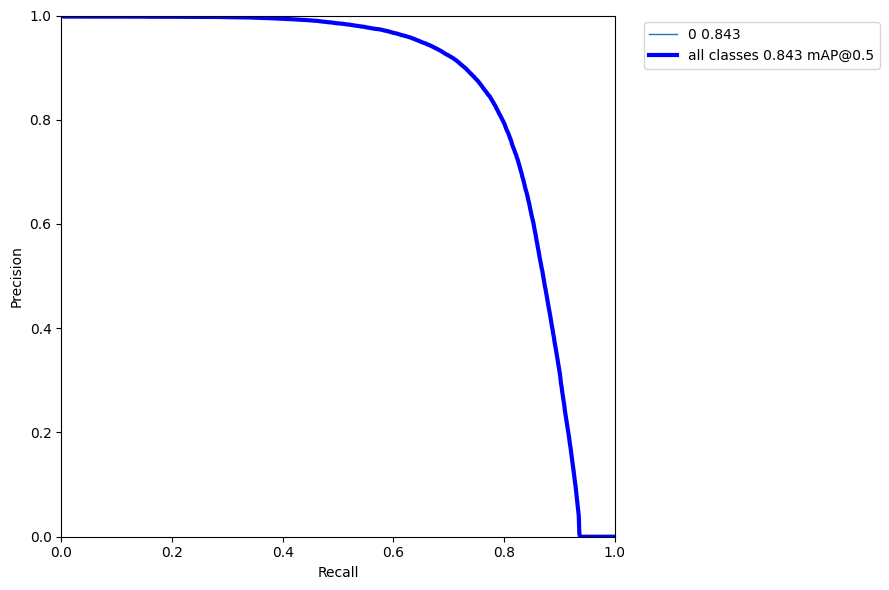

In [54]:
from lib.utils import DataLoaderX
 
valid_loader = DataLoaderX(
    val_day,
    batch_size=cfg.TEST.BATCH_SIZE_PER_GPU * len(cfg.GPUS),
    shuffle=False,
    num_workers=cfg.WORKERS,
    pin_memory=False,
    collate_fn=dataset.AutoDriveDataset.collate_fn
)

print('load data finished')
epoch = 0
da_segment_results,ll_segment_results,detect_results, total_loss,maps, times = validate(
    epoch,cfg, valid_loader, val_day, model, criterion,
    "", "", "",
    "", device
)

fi = fitness(np.array(detect_results).reshape(1, -1))
msg =   'Test:    Loss({loss:.3f})\n' \
        'Driving area Segment: Acc({da_seg_acc:.3f})    IOU ({da_seg_iou:.3f})    mIOU({da_seg_miou:.3f})\n' \
                  'Lane line Segment: Acc({ll_seg_acc:.3f})    IOU ({ll_seg_iou:.3f})  mIOU({ll_seg_miou:.3f})\n' \
                  'Detect: P({p:.3f})  R({r:.3f})  mAP@0.5({map50:.3f})  mAP@0.5:0.95({map:.3f})\n'\
                  'Time: inference({t_inf:.4f}s/frame)  nms({t_nms:.4f}s/frame)'.format(
                      loss=total_loss, da_seg_acc=da_segment_results[0],da_seg_iou=da_segment_results[1],da_seg_miou=da_segment_results[2],
                      ll_seg_acc=ll_segment_results[0],ll_seg_iou=ll_segment_results[1],ll_seg_miou=ll_segment_results[2],
                      p=detect_results[0],r=detect_results[1],map50=detect_results[2],map=detect_results[3],
                      t_inf=times[0], t_nms=times[1])

print(msg)